In [1]:
import sys
sys.path.append('../')

import gc
import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats

#from sa_decomp_layer import SADecompLayer



import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


#tf.__version__
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16, ResNet152, ResNet50

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp
from glob import glob


from tensorflow.keras.utils import to_categorical
from tensorflow.data import Dataset, AUTOTUNE
from imagenet_utils.imagenet_clsloc2 import clsloc
from imagenet_utils.load_images import load_images
from imagenet_utils.preprocess import preprocess

from utils.utils import *

import keras
from keras import layers

from keras import backend as K

import scienceplots

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})


In [2]:
gc.collect()
model = VGG16(weights='imagenet',
				  include_top=True,
				  input_shape=(224, 224, 3))

model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=False),            
			metrics=[
				keras.metrics.CategoricalAccuracy(name="accuracy"),
				keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),])


In [ ]:
def rotateActivation (model_original, l_num, k=1)  :
	model = tf.keras.models.clone_model(model_original)
	model.set_weights(model_original.get_weights())
	conv_layers = []
	for l in model.layers:
		if 'conv2d' in str(type(l)).lower():
			if l.kernel_size == (3,3):
				conv_layers.append(l)
	print(conv_layers[l_num])
	print(l_num)


	target_layer = conv_layers[l_num]
	target_index = model.layers.index(target_layer)
	
	# Insert a Lambda layer after the target layer
	x = model.input
	for i in range(1, target_index + 1):
		x = model.layers[i](x)
	
	# Add the rotation
	x = tf.keras.layers.Lambda(lambda x: tf.image.rot90(x, k=k), name=f"rotate_activation_{l_num}")(x)
	
	# Continue with the remaining layers
	for i in range(target_index + 1, len(model.layers)):
		x = model.layers[i](x)
	
	rotated_model = tf.keras.Model(inputs=model.input, outputs=x)
	return rotated_model	




In [4]:
# Imagenet Validation Set location
img = "C:/ILSVRC2012_img_val/ILSVRC2012_val_00000028.JPEG"

In [5]:
train_list = glob("C:/imagenette2/train/*/*.JPEG")
train_labels = glob("C:/imagenette2/train/*/*.JPEG")
train_labels = to_categorical([clsloc[os.path.normpath(str(path)).split(os.path.sep)[-2]] for path in train_labels], num_classes = 1000)


trainDS = Dataset.from_tensor_slices((train_list, train_labels))
trainDS = (trainDS
	.map(load_images)
	.map(preprocess)
	.cache()
	.batch(1)
	.prefetch(AUTOTUNE)
)


val_list = glob("C:/imagenette2/val/*/*.JPEG")
val_labels = glob("C:/imagenette2/val/*/*.JPEG")
val_labels = to_categorical([clsloc[os.path.normpath(str(path)).split(os.path.sep)[-2]] for path in val_list], num_classes = 1000)


valDS = Dataset.from_tensor_slices((val_list, val_labels))
valDS = (valDS
	.map(load_images)
	.map(preprocess)
	.cache()
	.batch(32)
	.prefetch(AUTOTUNE)
)

In [6]:
x = [1,2,3]
x[1:]

[2, 3]

In [7]:
gc.collect()

model_rot = rotateActivation(model, 2, 2)

model_rot.summary()

2
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 rotate_activation_2 (Lambda  (None, 112, 112, 128)    0         
 )                                                               
                                                           

In [8]:
#model_rot.evaluate(valDS)

In [9]:
x,y = list(valDS.take(1))[0]

In [10]:
split_model_rot = tf.keras.Model(model_rot.inputs, model_rot.get_layer('block2_conv2').output)

1/1 [==============================] - 78s 78s/step


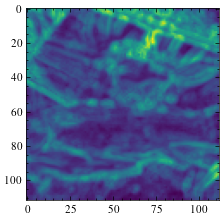

In [11]:
plt.imshow(tf.reduce_sum(split_model_rot.predict(x)[0], axis=(-1)))

1/1 [==============================] - 0s 111ms/step


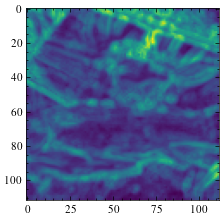

In [12]:
split_model = tf.keras.Model(model.inputs, model.get_layer("block2_conv2").output)
plt.imshow(tf.reduce_sum(split_model.predict(x)[0], axis=(-1)))

In [13]:
model.evaluate(valDS)

123/123 [==============================] - 72s 557ms/step - loss: 0.6939 - accuracy: 0.8028 - top-5-accuracy: 0.9546


[0.6938567161560059, 0.802802562713623, 0.9546496868133545]